Benchmark the context-based DOI computation against a no-context baseline and compare it with the ground truth of computing the DOI for all data at once.

In [1]:
import os
from sys import path
from time import time

import numpy as np

cwd = os.getcwd()
path.append(f"{cwd}/..")

from database import (create_tables, drop_tables, get_next_chunk_from_db,
                      reset_progression, save_dois, update_dois)
from doi_function import (compute_dois, reset_doi_component,
                          set_dimension_weights, set_dimension_intervals)

from server import taxi_process_chunk


def reset(weights: dict, intervals: dict): 
  drop_tables()

  create_tables(
      row_data_path="../data/nyc_taxis.shuffled_full.csv.gz",
      column_data_path="../data/nyc_taxis.shuffled_full.parquet",
      id_column="tripID",
      total_size=112145904,
      process_chunk_callback=taxi_process_chunk,
  )

  reset_progression()
  reset_doi_component()
  set_dimension_weights(weights)
  set_dimension_intervals(intervals)

doi_storage_ground_truth = {}
doi_storage_optimized = {}
doi_storage_baseline = {}

def benchmark(iterations: int, chunk_size: int, weights: dict, intervals: dict):

  ##################################################################################################
  # TEST_CASE
  ##################################################################################################
  reset(weights, intervals)
  now = time()
  for i in range(iterations):
    chunk = get_next_chunk_from_db(chunk_size)
    new_dois, updated_ids, updated_dois = compute_dois(chunk, use_optimizations=True)

    new_ids = np.array(chunk)[:, 0].tolist()
    updated_ids = np.array(updated_ids).tolist()

    save_dois(new_ids, new_dois.reshape(-1, ).tolist())
    update_dois(updated_ids, updated_dois.reshape(-1, ).tolist())

    for i, new_id in enumerate(new_ids):
      doi_storage_optimized[str(new_id)] = new_dois[i][0]

    for i, updated_id in enumerate(updated_ids):
      doi_storage_optimized[str(updated_id)] = updated_dois[i][0]

  print("optimized:", time() - now, "s")

  ##################################################################################################
  # BASELINE
  ##################################################################################################
  reset(weights, intervals)
  set_dimension_weights(weights)
  set_dimension_intervals(intervals)
  now = time()
  for i in range(iterations):
    chunk = get_next_chunk_from_db(chunk_size)
    new_dois, _, _ = compute_dois(chunk, use_optimizations=False)

    new_ids = np.array(chunk)[:, 0].tolist()

    for i, new_id in enumerate(new_ids):
      doi_storage_baseline[str(new_id)] = new_dois[i][0]
      
  print("baseline:", time() - now, "s")

  ##################################################################################################
  # GROUND TRUTH
  ##################################################################################################
  reset(weights, intervals)
  now = time()
  chunk = get_next_chunk_from_db(chunk_size * iterations)
  new_dois, _, _ = compute_dois(chunk, use_optimizations=False)

  new_ids = np.array(chunk)[:, 0].tolist()

  for i, new_id in enumerate(new_ids):
    doi_storage_ground_truth[str(new_id)] = new_dois[i][0]

  print("ground truth:", time() - now, "s")


ITERATIONS = 100
CHUNK_SIZE = 1000
WEIGHTS = {
  "trip_distance": 0.25,
  "total_amount": 0.25,
  "tip_amount": 0.25,
  "trip_duration": 0.25,
}
INTERVALS = {
  "trip_distance": [16, 20],
  "total_amount": [34, 74],
  "tip_amount": [4, 12],
  "trip_duration": [3, 5],
}

benchmark(ITERATIONS, CHUNK_SIZE, WEIGHTS, INTERVALS)

optimized: 146.8007435798645 s
baseline: 52.16898965835571 s
ground truth: 11.662999391555786 s


Plot baseline and test case against the ground truth

<AxesSubplot:>

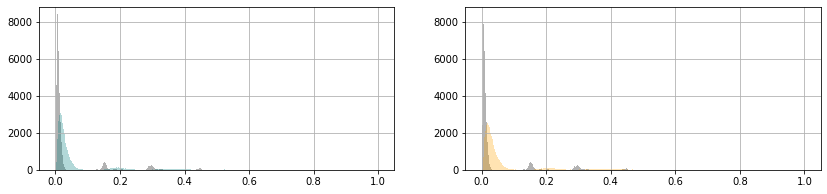

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

figsize = (14, 3)
fig, axes = plt.subplots(1, 2, figsize=figsize)

bin_size = 0.001
bins = np.arange(0, 1 + bin_size, bin_size)
pd.Series(doi_storage_ground_truth).hist(bins=bins, ax=axes[0], alpha=0.3, color="black")
pd.Series(doi_storage_optimized).hist(bins=bins, ax=axes[0], alpha=0.3, color="teal")

pd.Series(doi_storage_ground_truth).hist(bins=bins, ax=axes[1], alpha=0.3, color="black")
pd.Series(doi_storage_baseline).hist(bins=bins, ax=axes[1], alpha=0.3, color="orange")

Summarize the benchmarks with basic descriptive statistics.

In [4]:
import pandas as pd

gt_df = pd.Series(doi_storage_ground_truth).sort_index()
optimized_df = pd.Series(doi_storage_optimized).sort_index()
baseline_df = pd.Series(doi_storage_baseline).sort_index()


df = pd.DataFrame(columns=["gt", "baseline", "optimized"], index=gt_df.index)

df["gt"] = gt_df.to_numpy()
df["baseline"] = baseline_df.to_numpy()
df["optimized"] = optimized_df.to_numpy()

# sanity check:
assert (df["gt"] - gt_df).sum() == 0.0
assert (df["baseline"] - baseline_df).sum() == 0.0
assert (df.index != baseline_df.index).sum() == 0.0
assert (df["optimized"] - optimized_df).sum() == 0.0
assert (df.index != optimized_df.index).sum() == 0.0

baseline_error = df["gt"] - df["baseline"]
optimized_error = df["gt"] - df["optimized"]

"baseline", baseline_error.describe(), "optimized", optimized_error.describe()

('baseline',
 count    100000.000000
 mean         -0.028479
 std           0.030859
 min          -0.344976
 25%          -0.032551
 50%          -0.018979
 75%          -0.011182
 max          -0.000053
 dtype: float64,
 'optimized',
 count    100000.000000
 mean         -0.020795
 std           0.023960
 min          -0.255620
 25%          -0.023900
 50%          -0.013560
 75%          -0.007508
 max          -0.000002
 dtype: float64)

Benchmark the new `DoiRegressionModel` class

In [7]:
import os
from sys import path

cwd = os.getcwd()
path.append(f"{cwd}/..")
import numpy as np
import pandas as pd
from database import (create_tables, drop_tables, get_next_chunk_from_db,
                      reset_progression)
from doi_function import (compute_dois, reset_doi_component,
                          set_dimension_intervals, set_dimension_weights)
from doi_regression_model import *
from storage_strategy.windowing_storage import WindowingStorage

from server import taxi_process_chunk


def reset(weights: dict, intervals: dict): 
  drop_tables()

  create_tables(
      row_data_path="../data/nyc_taxis.shuffled_full.csv.gz",
      column_data_path="../data/nyc_taxis.shuffled_full.parquet",
      id_column="tripID",
      total_size=112145904,
      process_chunk_callback=taxi_process_chunk,
  )

  reset_progression()
  reset_doi_component()
  set_dimension_weights(weights)
  set_dimension_intervals(intervals)


CHUNK_SIZE = 1000
WEIGHTS = {
  "trip_distance": 0.25,
  "total_amount": 0.25,
  "tip_amount": 0.25,
  "trip_duration": 0.25,
}
INTERVALS = {
  "trip_distance": [16, 20],
  "total_amount": [34, 74],
  "tip_amount": [4, 12],
  "trip_duration": [3, 5],
}

reset(intervals=INTERVALS, weights=WEIGHTS)


def get_next_progressive_result(storage: StorageStrategy, get_context = None):
  '''Wrapper function for getting a new chunk, computing the DOI function on it and storing the data
     for later retrieval in the storage.'''

  # get chunk and compute context
  chunk_df = get_next_chunk_from_db(CHUNK_SIZE, as_df=True)
  
  context_df = pd.DataFrame([], columns = chunk_df.columns)
  if get_context is not None:
    context_df = get_context()

  # compute the DOI over chunk + context
  df = pd.concat([chunk_df, context_df], ignore_index=True)
  dois = compute_dois(pd.DataFrame(df.to_numpy()))  # HACK: compatibility with DoiComponent class
  new_dois = dois[:len(chunk_df)]

  storage.insert_chunk(chunk_df, 0)

  # remove non-numerical columns as they crash the tree's training step
  drop_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "store_and_fwd_flag", "duration", "ratio"]
  chunk_df = chunk_df.drop(columns=drop_cols) 
  chunk_df = chunk_df.astype(np.float32)

  return chunk_df, new_dois


def benchmark_max_depth(tested_max_depths: range = range(1, 10), n_chunks: int = 25):
  '''Tests how varying `max_depth` parameter influences progressive DOI prediction scores.'''
  scores = []

  for test_case_depth in tested_max_depths:
    reset(intervals=INTERVALS, weights=WEIGHTS)
    storage = WindowingStorage(max_size=10000000)
    model = DoiRegressionModel(storage, max_depth=test_case_depth)

    test_case_scores_per_chunk = []
    for i in range(n_chunks):
      chunk_df, new_dois = get_next_progressive_result(storage)
      if i == 0:
        model.update(chunk_df, new_dois)
      test_case_scores_per_chunk += [model.score(chunk_df, new_dois)]
    scores += [test_case_scores_per_chunk]
  
  return pd.DataFrame(np.array(scores).T, columns=tested_max_depths)


def benchmark_retraining_intervals(tested_intervals: range = range(25), max_depth: int = 3, n_chunks: int = 25):
  '''Tests how varying the update interval influences progressive DOI prediction scores.'''
  scores = []

  for test_case_interval in tested_intervals:
    reset(intervals=INTERVALS, weights=WEIGHTS)
    storage = WindowingStorage(max_size=10000000)
    model = DoiRegressionModel(storage, max_depth=max_depth)

    test_case_scores_per_chunk = []
    for i in range(n_chunks):
      chunk_df, new_dois = get_next_progressive_result(storage)
      if test_case_interval == 0 or i % test_case_interval == 0:
        model.update(chunk_df, new_dois)
      test_case_scores_per_chunk += [model.score(chunk_df, new_dois)]
    scores += [test_case_scores_per_chunk]

  return pd.DataFrame(np.array(scores).T, columns=tested_intervals)

def benchmark_context(update_interval: int = 8, max_depth: int = 3, n_chunks: int = 25):  
  scores_with_context = []
  context_size = 1000
  reset(intervals=INTERVALS, weights=WEIGHTS)
  storage = WindowingStorage(max_size=10000000)
  model = DoiRegressionModel(storage, max_depth=max_depth)
  for i in range(n_chunks):
      # model is not yet trained at first chunk, so no context ...
      if i == 0:
        chunk_df, new_dois = get_next_progressive_result(storage)
      # ... otherwise use context
      else:
        chunk_df, new_dois = get_next_progressive_result(
          storage,
          lambda: model.get_context_items(context_size)
        )

      if i % update_interval == 0:
        model.update(chunk_df, new_dois)
      scores_with_context += [model.score(chunk_df, new_dois)]

  scores_without_context = []
  reset(intervals=INTERVALS, weights=WEIGHTS)
  storage = WindowingStorage(max_size=10000000)
  model = DoiRegressionModel(storage, max_depth=max_depth)
  for i in range(n_chunks):
      chunk_df, new_dois = get_next_progressive_result(storage)
      if i % update_interval == 0:
        model.update(chunk_df, new_dois)
      scores_without_context += [model.score(chunk_df, new_dois)]


  scores = [scores_with_context, scores_without_context]

  return pd.DataFrame(np.array(scores).T, columns=["context", "no context"])

# results: max_depth = 3 has best peformance, then no improvement/worse for bigger values
max_depth_results = benchmark_max_depth()

# results: trivial best results for 0 and 1, score std for 3-8 above 0.9 
intervals_results = benchmark_retraining_intervals()

# results: when including context items in the doi computation, scores drop.
context_results = benchmark_context()

Plot the prediction scores of the regression model across varying `max_depth` parameters.

<AxesSubplot:>

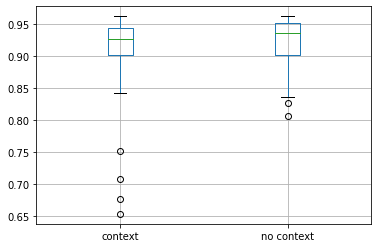

In [8]:
context_results.boxplot()